In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
# import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader


import os


import warnings

warnings.filterwarnings("ignore")
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    deprocess_image,
    preprocess_image,
)
from PIL import Image

In [2]:
data_dir = "/home/ltarricone/ml4h_data/project1/chest_xray/chest_xray"

In [3]:
class PneumoniaModelBase(nn.Module):
    """
    Base class that will have all the useful methods for the training of the model
    """
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  


class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)

In [4]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = True

    model.eval()
    return model

model = load_checkpoint('./PneumoniaResnet.pth')

In [5]:
model.to('cpu')

PneumoniaResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

img shape pre (840, 1136)


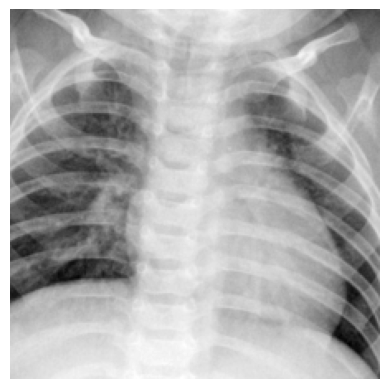

input_tensor shape:  torch.Size([1, 3, 224, 224])


In [46]:
img = np.array(
    Image.open(os.path.join(data_dir, "train/PNEUMONIA/person1036_virus_1730.jpeg"))
)

img = np.float32(img) / 255


print('img shape pre', img.shape)

transformation = T.Compose([
    T.ToTensor(),
    T.Resize(260),                                 
    T.CenterCrop(224),
])

input_tensor = transformation(img)

input_tensor = torch.cat([input_tensor,input_tensor,input_tensor])

input_tensor = input_tensor.unsqueeze(0)

image_np = input_tensor[0,0,:,:].numpy()  # Convert to numpy array and move to CPU if necessary

# Plot the image
plt.imshow(image_np, cmap = 'grey')
plt.axis('off')  # Turn off axis
plt.show()

print('input_tensor shape: ', input_tensor.shape)

(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224, 3)


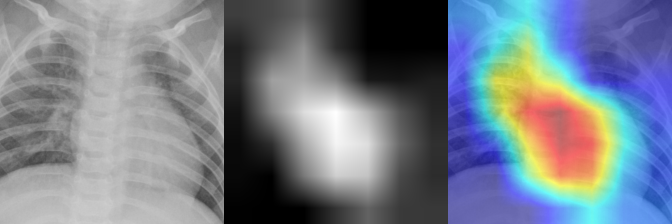

In [47]:
# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.


targets = [ClassifierOutputTarget(1)]
target_layers = [model.network.layer4[-1]]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)[0,:]
    #make image 3 channels
    img = cv2.merge([image_np, image_np, image_np])
    print(img.shape)
    cam_image = show_cam_on_image(img, grayscale_cams, use_rgb=True)

cam = np.uint8(255 * grayscale_cams)
print(cam.shape)
cam = cv2.merge([cam, cam, cam])
print(cam.shape)
print(cam_image.shape)
images = np.hstack((np.uint8(255 * img), cam, cam_image))
#plot images with bigger size 
Image.fromarray(images)
